In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
import SenseEmb
import SenseEmb.sense_vec_hdim as shdim

In [4]:
import json
from tqdm.auto import tqdm

In [5]:
import numpy.linalg as la
import numpy as np
from math import gamma, lgamma
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist, squareform

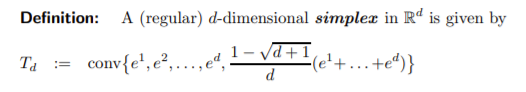

In [6]:
def get_n_simplex(n, s=1):
    coords = np.zeros(shape=(n+1, n))
    for i in range(n):
        coords[i][i] = 1
    coords[n] = (1-np.sqrt(n+1))/n * np.ones(n)
    return (coords-coords.mean(0))/np.sqrt(2) * s

In [7]:
coords = get_n_simplex(3, 2)
print(squareform(pdist(coords)))
print(coords.mean(0))

[[0. 2. 2. 2.]
 [2. 0. 2. 2.]
 [2. 2. 0. 2.]
 [2. 2. 2. 0.]]
[-5.55111512e-17 -5.55111512e-17 -2.77555756e-17]


In [8]:
coords = get_n_simplex(50, 1)
coords.shape

(51, 50)

In [9]:
from scipy.spatial.distance import pdist, squareform
squareform(pdist(coords))

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [10]:
coords_r1 = coords / la.norm(coords, axis=1)[:, np.newaxis]

In [11]:
squareform(pdist(coords_r1))

array([[0.        , 1.42828569, 1.42828569, ..., 1.42828569, 1.42828569,
        1.42828569],
       [1.42828569, 0.        , 1.42828569, ..., 1.42828569, 1.42828569,
        1.42828569],
       [1.42828569, 1.42828569, 0.        , ..., 1.42828569, 1.42828569,
        1.42828569],
       ...,
       [1.42828569, 1.42828569, 1.42828569, ..., 0.        , 1.42828569,
        1.42828569],
       [1.42828569, 1.42828569, 1.42828569, ..., 1.42828569, 0.        ,
        1.42828569],
       [1.42828569, 1.42828569, 1.42828569, ..., 1.42828569, 1.42828569,
        0.        ]])

In [12]:
coords_r1.shape

(51, 50)

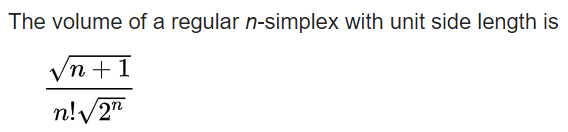

In [14]:
def n_simplex_volume(n, s=1, log=False):    
    if log:
        return (n*np.log(s) + 
                0.5*np.log(n+1) - 
                np.log(np.arange(1,n+1)).sum() - 
                n/2*np.log(2))
    else:
        return np.sqrt(n+1)*(s**n) / (np.math.factorial(n) * np.sqrt(2**n))
        

In [15]:
print(la.det(np.hstack([coords_r1, np.ones((51, 1))])))
print(la.det(np.hstack([coords_r1, np.ones((51, 1))]))/np.math.factorial(50))
print(n_simplex_volume(50, 1.42828))

11.71627028890816
3.852250406153199e-64
3.851483730503573e-64


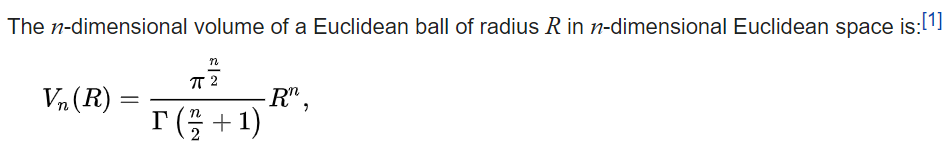

In [18]:
gamma(1)

1.0

In [19]:
def n_ball_volume(n, r=1, log=False):
    if log:
        return n/2*np.log(np.pi) - lgamma(n/2+1) + n*np.log(r)
    else:
        return (np.pi**(n/2))/(gamma(n/2+1)) * (r**n)

In [22]:
coords = get_n_simplex(3, 2)
ConvexHull(coords).volume, n_simplex_volume(3, 2)

(0.942809041582063, 0.9428090415820632)

## Sense volume augmented by n-simplex

In [23]:
skv = SenseEmb.SenseKeyedVectors.load_from_kv("../data/sense-emb-asbc5-600k-d50.kv")

In [24]:
from sklearn.decomposition import PCA

In [25]:
k = skv.vectors.shape[1]

In [150]:
def gram_vol(vecs, log=False):
    gram_det = la.det(vecs.T.dot(vecs))
    vol = np.sqrt(gram_det)
    if log:
        return np.log(vol)
    else:
        return vol

def compute_sense_volume(word, verbose=True):
    try:
        sdata = skv.make_sense_vectors(word)    
    except ValueError:
        return {}        
            
    n_sense = sdata.sense_vecs.shape[0]    
    s_idx = np.argmax(sdata.sense_freqs)
    
    simplex = get_n_simplex(k, s=1) + sdata.sense_vecs[s_idx, :]    
    svecs = np.vstack([sdata.sense_vecs, simplex])            

    ori = svecs[s_idx, :]
    osvecs = svecs - ori
    nsvecs = svecs / la.norm(svecs, axis=0)[np.newaxis, :]
    onsvecs = nsvecs - nsvecs[s_idx, :]
    
    vol_svecs = gram_vol(svecs)
    vol_osvecs = gram_vol(osvecs)
    vol_nsvecs = gram_vol(nsvecs)
    vol_onsvecs = gram_vol(onsvecs)
    
    if verbose:
        print("%18s" % (f"--- {word} ---", ))
        print("%14s: %d" % ("n_sense", n_sense))
        print("%10s log|V|: %g" % ("raw", vol_svecs))
        print("%10s log|V|: %g" % ("centered", vol_osvecs))
        print("%10s log|V|: %g" % ("normalized", vol_nsvecs))
        print("%10s log|V|: %g" % ("cen+norm", vol_onsvecs))
    return dict(n_sense=n_sense, 
                V_raw=vol_svecs, 
                V_cen=vol_osvecs, 
                V_norm=vol_nsvecs, 
                V_cennorm = vol_onsvecs)

## Some examples

In [151]:
compute_sense_volume("開");

         --- 開 ---
       n_sense: 62
       raw log|V|: 0.904923
  centered log|V|: 0.193008
normalized log|V|: 5.49297e-10
  cen+norm log|V|: 1.17158e-10


In [152]:
compute_sense_volume("打")

         --- 打 ---
       n_sense: 73
       raw log|V|: 6.39949
  centered log|V|: 1.34294
normalized log|V|: 1.11038e-09
  cen+norm log|V|: 2.33015e-10


{'n_sense': 73,
 'V_raw': 6.399485632583088,
 'V_cen': 1.3429383620671478,
 'V_norm': 1.110381727032566e-09,
 'V_cennorm': 2.330146988967443e-10}

In [153]:
compute_sense_volume("條")

         --- 條 ---
       n_sense: 19
       raw log|V|: 3.23199e-05
  centered log|V|: 4.19352e-06
normalized log|V|: 3.65386e-10
  cen+norm log|V|: 4.74089e-11


{'n_sense': 19,
 'V_raw': 3.2319933252496204e-05,
 'V_cen': 4.1935182831029375e-06,
 'V_norm': 3.6538555704369303e-10,
 'V_cennorm': 4.7408854525594476e-11}

In [154]:
compute_sense_volume("言")

         --- 言 ---
       n_sense: 8
       raw log|V|: 5.12138e-06
  centered log|V|: 8.28631e-07
normalized log|V|: 2.04641e-09
  cen+norm log|V|: 3.31105e-10


{'n_sense': 8,
 'V_raw': 5.1213794156361e-06,
 'V_cen': 8.286313791096315e-07,
 'V_norm': 2.046406160037772e-09,
 'V_cennorm': 3.311053958301473e-10}

In [155]:
compute_sense_volume("丁")

         --- 丁 ---
       n_sense: 3
       raw log|V|: 5.34645e-07
  centered log|V|: 5.43008e-08
normalized log|V|: 8.42381e-09
  cen+norm log|V|: 8.55558e-10


{'n_sense': 3,
 'V_raw': 5.346450432212135e-07,
 'V_cen': 5.430082475434502e-08,
 'V_norm': 8.42381210282911e-09,
 'V_cennorm': 8.55558188669106e-10}

In [98]:
compute_sense_volume("總統")

{}

In [156]:
with open("../data/sense_counts_monoword.json", "r", encoding="UTF-8") as fin:
    sense_counts = json.load(fin)

In [157]:
results = []
for word, n_sense in tqdm(sense_counts.items()):
    if n_sense < 1: continue
    indices = compute_sense_volume(word, verbose=False)
    if indices:
        results.append({"word": word, **indices})

In [159]:
import pandas as pd
vol_df = pd.DataFrame.from_records(results)

Text(0.5, 0, 'n')

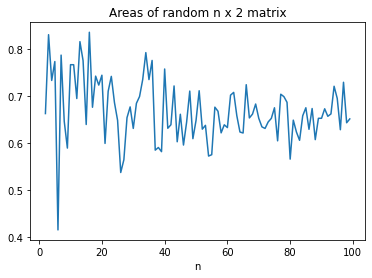

In [170]:
x_vols = []
xs = np.arange(2, 100)
for n in xs:
    X = np.random.uniform(size=(n, 2))
    X = X/la.norm(X, axis=0)[np.newaxis, :]
    x_vols.append(gram_vol(X))
plt.plot(xs, x_vols)
plt.title("Areas of random n x 2 matrix")
plt.xlabel("n")

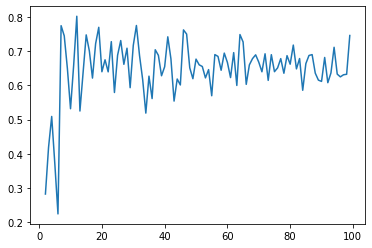

Text(0, 0.5, 'log Vnorm')

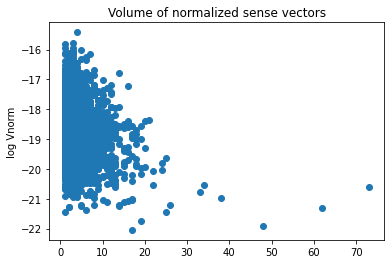

In [165]:
plt.scatter(vol_df.n_sense, np.log(vol_df.V_norm))
plt.title("Volume of normalized sense vectors")
plt.ylabel("log Vnorm")

Text(0, 0.5, 'log V centered-norm')

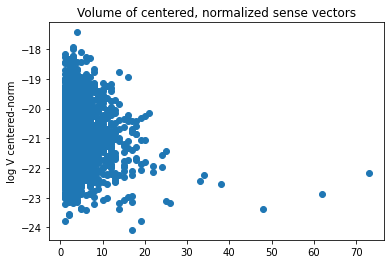

In [168]:
plt.scatter(vol_df.n_sense, np.log(vol_df.V_cennorm))
plt.title("Volume of centered, normalized sense vectors")
plt.ylabel("log V centered-norm")

In [106]:
np.corrcoef(np.log(vol_df.n_sense, np.log(vol_df.V_cennorm))

array([[1.       , 0.7906697],
       [0.7906697, 1.       ]])

In [83]:
from scipy.stats import spearmanr

In [84]:
spearmanr(vol_df.n_sense, np.log(vol_df.V_cennorm))

SpearmanrResult(correlation=0.9808235354364573, pvalue=0.0)

## for reference: 50-ball and 50-simplex volumes

In [36]:
simplex_r1 = get_n_simplex(k, s=1)
simplex_r1 = simplex_r1 / la.norm(simplex_r1, axis=1)[:, np.newaxis]
simplex_r1slen = pdist(simplex_r1)[0]
simplex_r1vol = n_simplex_volume(k, simplex_r1slen)

print("side length inscribed in unit circle: ", simplex_r1slen)
print("%20s |V|: %g" % ("n-parallelotope", n_simplex_volume(50)*np.math.factorial(50), ))
print("%20s |V|: %g" % ("n-simplex", n_simplex_volume(50), ))
print("%20s |V|: %g" % ("n-simp-r1", simplex_r1vol))
print("%20s |V|: %g" % ("n-ball", n_ball_volume(50),))

side length inscribed in unit circle:  1.4282856857085697
     n-parallelotope |V|: 2.12831e-07
           n-simplex |V|: 6.99778e-72
           n-simp-r1 |V|: 3.85225e-64
              n-ball |V|: 1.73022e-13


In [184]:
test_svec = np.random.uniform(size=(1, 50))
simplex = get_n_simplex(k, s=1) + test_svec
svecs = np.vstack([test_svec, simplex])   

In [186]:
gram_vol(svecs)

1.2039394693536618e-06

In [188]:
simplex.shape

(51, 50)

In [189]:
svecs.shape

(52, 50)

## Determinant Sandbox

In [1]:
import numpy as np
import numpy.linalg as la
sq2 = np.sqrt(2)
X = np.array([[1, 0], [0, 1], [1/sq2, 1/sq2], [np.sqrt(3)/2, 1/2]])
X

array([[1.        , 0.        ],
       [0.        , 1.        ],
       [0.70710678, 0.70710678],
       [0.8660254 , 0.5       ]])

In [13]:
Qx, Rx = la.qr(X)

In [14]:
Qx

array([[-0.66666667,  0.3551733 ],
       [-0.        , -0.85651559],
       [-0.47140452, -0.35450253],
       [-0.57735027, -0.12066869]])

In [15]:
Rx

array([[-1.5       , -0.62200847],
       [ 0.        , -1.16752108]])

In [17]:
XtX = X.T.dot(X)
XtX

array([[2.25     , 0.9330127],
       [0.9330127, 1.75     ]])

In [40]:
lambs, evecs = la.eig(XtX)
lambs, evecs

(array([2.96592583, 1.03407417]),
 array([[ 0.79335334, -0.60876143],
        [ 0.60876143,  0.79335334]]))

In [54]:
XtX_sq = evecs.dot(np.diag(np.sqrt(lambs))).dot(evecs.T)
XtX_sq

array([[1.46081186, 0.34062987],
       [0.34062987, 1.27826887]])

In [53]:
XtX_sq.dot(XtX_sq), XtX

(array([[2.25     , 0.9330127],
        [0.9330127, 1.75     ]]),
 array([[2.25     , 0.9330127],
        [0.9330127, 1.75     ]]))

In [43]:
lambs.prod()

3.066987298107781

In [33]:
la.det(XtX), la.det(C) ** 2

(3.0669872981077813, 3.0669872981077813)

In [37]:
la.det(Rx)

1.7512816158767213

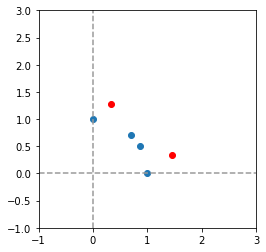

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], X[:, 1])
ax.scatter(XtX_sq[:, 0], XtX_sq[:, 1], color="red")
ax.set_xlim(-1, 3)
ax.set_ylim(-1, 3)
ax.axhline(0, color="#999", linestyle="--")
ax.axvline(0, color="#999", linestyle="--")
ax.set_aspect(1)

In [49]:
A = np.vstack([get_n_simplex(2)+[0,0], np.array([0,0])])

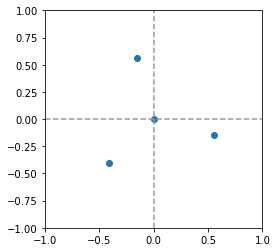

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.scatter(A[:, 0], A[:, 1])
# ax.scatter(XtX_sq[:, 0], XtX_sq[:, 1], color="red")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axhline(0, color="#999", linestyle="--")
ax.axvline(0, color="#999", linestyle="--")
ax.set_aspect(1)